<a href="https://colab.research.google.com/github/awiteck/DeepLearningProject/blob/main/yolo_implementation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow.keras.backend as K # For custom loss function
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, UpSampling2D, Concatenate, Reshape, GlobalAveragePooling2D, Input, Dense, MaxPooling2D
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from sklearn.model_selection import train_test_split

import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/DeepLearningProject/data"

In [ ]:
df = pd.read_csv(f'{data_path}/train_solution_bounding_boxes.csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
img_h, img_w, num_channels = (380, 676, 3)
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
# df = df.drop('image_id', 1)
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [209]:
import os
import cv2
import numpy as np

# Path to your images
image_folder = f'{data_path}/training_images/'

compression = 2

# Shape of input image
input_shape = (int(676//compression), int(380//compression), 3)
num_boxes = 5
num_classes = 1

# Number of grid cells
grid_w = input_shape[1] // 32
grid_h = input_shape[0] // 32


In [210]:
grid_w, grid_h

(5, 10)

In [211]:
def load_images_and_boxes(df):
    images = []
    target = []

    imageset = set()

    for _, row in df.iterrows():

      if row['image_id'] in imageset: 
        continue 
      else:
        imageset.add(row['image_id'])

        # Load image
        image = cv2.imread(os.path.join(image_folder, row['image_id'] + '.jpg'))
        image = cv2.resize(image, (input_shape[0], input_shape[1]))  # Ensure the image is resized to match the input_shape
        image = image / 255.  # Normalize pixel values to [0, 1]
        images.append(image)

        rows = df[df['image_id'] == row['image_id']]

        # Create an empty array to hold target data
        label_matrix = np.zeros((grid_w, grid_h, num_boxes, 5 + num_classes))

        offset = np.zeros((grid_w, grid_h))

        for _, subrow in rows.iterrows():
          # Get box parameters
          x_center = subrow['x_center']
          y_center = subrow['y_center']
          w = subrow['w']
          h = subrow['h']

          # Determine the grid cell for the box (remember that y is the row index and x is the column index here)
          grid_x = int(x_center * grid_w)
          grid_y = int(y_center * grid_h)

          # Set the box parameters and class probabilities (class 1 at index 0 because there's only one class)
          label_matrix[grid_x, grid_y, int(offset[grid_x, grid_y])] = np.array([x_center, y_center, w, h, 1, 1])
          offset[grid_x, grid_y]+=1

        target.append(label_matrix)

    return np.array(images), np.array(target)

In [212]:
# Assuming df is your dataframe
images, target = load_images_and_boxes(df)

In [213]:
images.shape, target.shape

((355, 190, 338, 3), (355, 5, 10, 5, 6))

Make sure data looks good

In [ ]:
# for i in range(target.shape[0]):
#   label = target[i]
#   if len(label[label>0]) > 6:
#     print(i)
#     print(label[label>0])

In [ ]:
input_shape

(338, 190, 3)

In [217]:
def create_model(input_shape, num_boxes, num_classes):
    image_input = Input(shape=(input_shape[1], input_shape[0], input_shape[2]))

    # Layer 1
    x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 4
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 5
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 6
    x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 7
    x = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_7', use_bias=False)(x)

    # Layer 8
    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_8', use_bias=False)(x)

    # Layer 9
    x = Conv2D(num_boxes * (4 + 1 + num_classes), (1, 1), strides=(1, 1), padding='same', name='conv_9')(x)
    output = Reshape((grid_w, grid_h, num_boxes, 4 + 1 + num_classes))(x)

    model = Model(image_input, output)
    
    return model



# Number of grid cells
grid_h = input_shape[0] // 32
grid_w = input_shape[1] // 32

model = create_model(input_shape, num_boxes, num_classes)
model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 190, 338, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 190, 338, 16)      432       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 95, 169, 16)      0         
 g2D)                                                            
                                                                 
 conv_2 (Conv2D)             (None, 95, 169, 32)       4608      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 47, 84, 32)       0         
 g2D)                                                            
                                                                 
 conv_3 (Conv2D)             (None, 47, 84, 64)        1843

In [219]:
def yolo_loss(y_true, y_pred):
    # Parameters to tweak the loss function
    lambda_coord = 5.0
    lambda_noobj = 0.5

    # Split the input tensors into their respective parts
    true_box = y_true[..., :4]
    true_obj = y_true[..., 4]
    
    pred_box = y_pred[..., :4]
    pred_obj = y_pred[..., 4]

    # Coordinate loss (only for boxes that contain an object)
    coord_mask = tf.expand_dims(true_obj, -1)
    coord_loss = tf.reduce_sum(tf.square(true_box - pred_box) * coord_mask)

    # Objectness loss (only for boxes that contain an object)
    obj_loss = tf.reduce_sum(tf.square(true_obj - pred_obj) * true_obj)

    # No-objectness loss (only for boxes that do not contain an object)
    noobj_loss = tf.reduce_sum(tf.square(true_obj - pred_obj) * (1 - true_obj))

    # Combine the losses
    loss = lambda_coord * coord_loss + obj_loss + lambda_noobj * noobj_loss

    return loss


In [220]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=yolo_loss)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs=20, 
    batch_size=32
)

Epoch 1/20
9/9 [==============================] - 51s 5s/step - loss: 180.9754 - val_loss: 87.3095
Epoch 2/20
9/9 [==============================] - 50s 6s/step - loss: 68.0496 - val_loss: 61.8622
Epoch 3/20
9/9 [==============================] - 46s 5s/step - loss: 55.3272 - val_loss: 57.2742
Epoch 4/20
9/9 [==============================] - 45s 5s/step - loss: 49.7039 - val_loss: 53.2617
Epoch 5/20
9/9 [==============================] - 45s 5s/step - loss: 46.9116 - val_loss: 51.6447
Epoch 6/20
9/9 [==============================] - 50s 6s/step - loss: 45.3561 - val_loss: 50.3911
Epoch 7/20
9/9 [==============================] - 45s 5s/step - loss: 44.2879 - val_loss: 49.8827
Epoch 8/20
9/9 [==============================] - 45s 5s/step - loss: 43.2466 - val_loss: 49.3358
Epoch 9/20
9/9 [==============================] - 46s 5s/step - loss: 42.6746 - val_loss: 49.7467
Epoch 10/20
9/9 [==============================] - 46s 5s/step - loss: 41.9245 - val_loss: 48.7862
Epoch 11/20
9/9 [=

In [221]:
model.save('obj-det-1.keras')

In [222]:
new_model = tf.keras.models.load_model('obj-det-2.h5', custom_objects = {'yolo_loss': yolo_loss})

# Evaluations

In [228]:
def load_test_images():
    images = []

    filelist = glob.glob(f'{data_path}/testing_images/*')

    for fname in filelist:
      image = cv2.imread(fname)
      image = cv2.resize(image, (input_shape[0], input_shape[1]))  # Ensure the image is resized to match the input_shape
      image = image / 255.  # Normalize pixel values to [0, 1]
      images.append(image)

    return np.array(images)

In [229]:
test_images = load_test_images()

In [230]:
test_images.shape

(175, 190, 338, 3)

In [231]:
preds = new_model.predict(test_images)

6/6 [==============================] - 7s 956ms/step


In [232]:
preds[0].shape

(5, 10, 5, 6)

In [235]:
pred = preds[0]
pred_boxes = pred[..., :4]
pred_objs = pred[..., 4]
for pred_obj in pred_objs:
  print(pred_obj)
  if pred_obj > 0.5:
    print("obj")

[[-0.00923057  0.04074381 -0.02837336  0.00258671 -0.0081055 ]
 [-0.02929905  0.04439083 -0.00883974  0.00083587 -0.00406234]
 [ 0.00637908  0.00722326  0.01003108 -0.03638789 -0.00855656]
 [-0.02430121 -0.0095371   0.02142956 -0.015429    0.00803471]
 [ 0.00979936  0.00459066  0.00321461 -0.00364418  0.00602617]
 [-0.00289428 -0.02719956  0.01553897  0.01011698  0.01764418]
 [-0.00799952 -0.0075111   0.0051527   0.00471612 -0.02840735]
 [-0.03629545 -0.02585272  0.01381582  0.01934198  0.00891159]
 [-0.02524002 -0.00179527  0.00811818 -0.01004102 -0.0078778 ]
 [ 0.01760282 -0.0123445   0.01311876  0.00797032 -0.00793066]]


ValueError: ignored

In [ ]:
for pred in preds:
  pred_box = pred[..., :4]
  pred_obj = pred[..., 4]
  if pred_obj > 0.5:
    print("obj")

In [198]:
def non_max_suppression(boxes, scores, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    
    Args:
    boxes: `numpy.ndarray` of shape `(N, 4)`.
    scores: `numpy.ndarray` of shape `(N,)`.
    threshold: float representing the threshold for IoU overlap.

    Returns:
    numpy.ndarray of shape `(K,)` representing indices of the kept boxes.
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= threshold)[0]
        order = order[inds + 1]

    return keep


## Get bounding boxes for first test image

In [199]:
# Predicted output from the model
output = preds[0]

# Split the output into box predictions and objectness score
boxes = output[..., :4]  # shape: (grid_h, grid_w, num_boxes, 4)
scores = output[..., 4]  # shape: (grid_h, grid_w, num_boxes)

# Reshape the arrays so that each box/score is a separate row
boxes = boxes.reshape(-1, 4)
scores = scores.reshape(-1)

# Convert box coordinates back to image coordinates
cell_height = input_shape[0] // grid_h
cell_width = input_shape[1] // grid_w

for i in range(boxes.shape[0]):
    # Get grid cell coordinates
    grid_y = i // (grid_w * num_boxes)
    grid_x = (i // num_boxes) % grid_w

    # Convert box coordinates
    boxes[i, 0] = boxes[i, 0] * cell_width + grid_x * cell_width  # x
    boxes[i, 1] = boxes[i, 1] * cell_height + grid_y * cell_height  # y
    boxes[i, 2] *= input_shape[1]  # width
    boxes[i, 3] *= input_shape[0]  # height

# Apply non-max suppression
indices = non_max_suppression(boxes, scores, threshold=0.5)

# The final bounding boxes are
final_boxes = boxes[indices]

In [200]:
final_boxes.shape

(232, 4)

In [202]:
test_images[0].shape

(338, 190, 3)

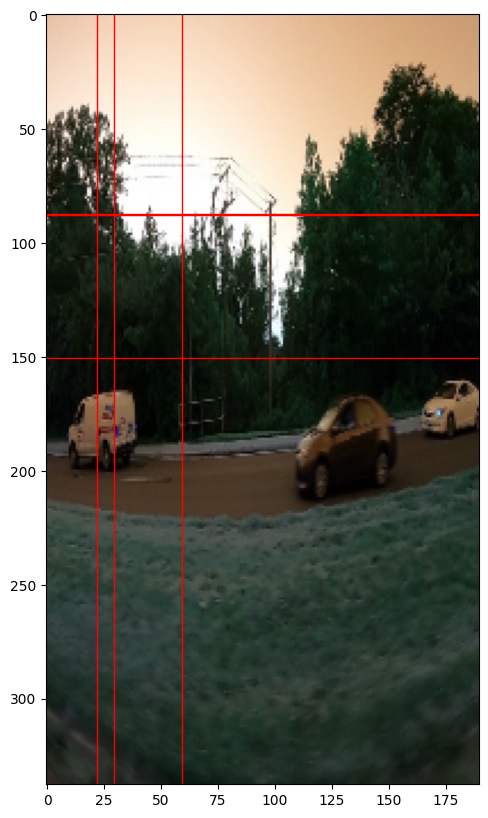

In [201]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load and display the image
plt.figure(figsize=(10,10))
plt.imshow(test_images[0])
ax = plt.gca()

# Draw the bounding boxes
for box in final_boxes:
    x, y, w, h = box
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

10

In [ ]:
def visualize_bbox(img, bbox):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = patches.Rectangle((bbox.iloc[0]['xmin'], 
                              bbox.iloc[0]['ymin']), 
                             bbox.iloc[0]['xmax'] - bbox.iloc[0]['xmin'], 
                             bbox.iloc[0]['ymax'] - bbox.iloc[0]['ymin'], 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

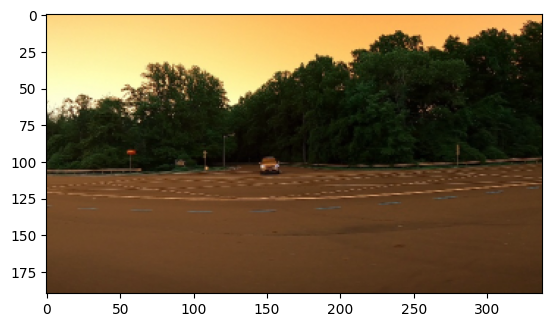

In [ ]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(images[0])

In [ ]:
label = target[0]
label[label>0]

array([0.45043415, 0.5398166 , 0.06874096, 0.0952381 , 1.        ,
       1.        ])

In [ ]:
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


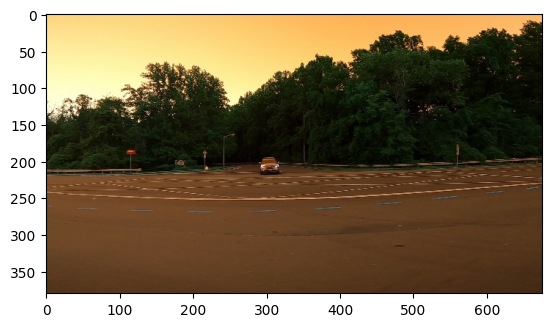

In [ ]:
image = cv2.imread(os.path.join(image_folder, "vid_4_1000" + '.jpg'))


In [ ]:
df[df["image_id"] == "vid_4_1000"]

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
